# 1. 样式迁移

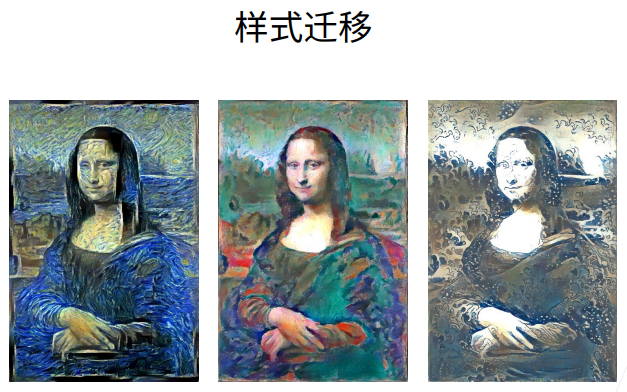

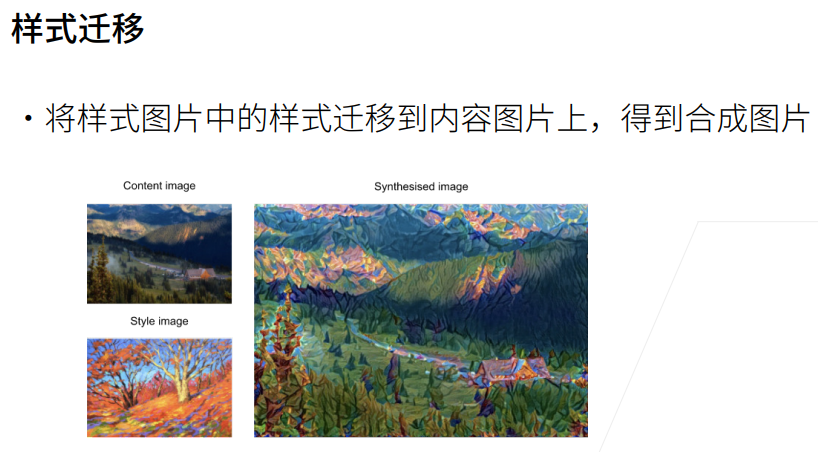

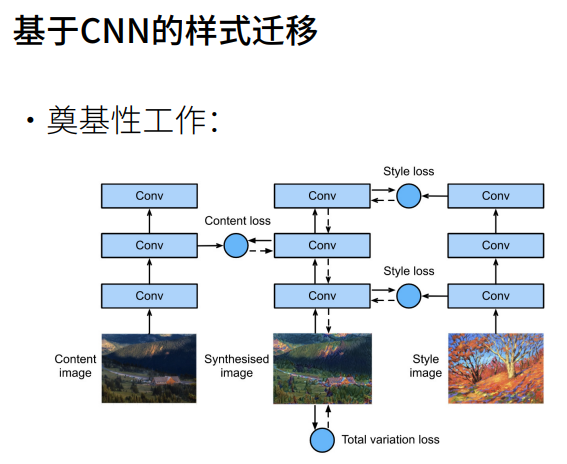

# 2. 样式迁移

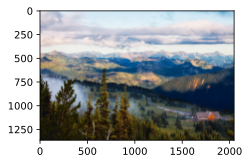

In [1]:
# 阅读内容和样式图像
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('01_Data/05_rainier.jpg')
d2l.plt.imshow(content_img)

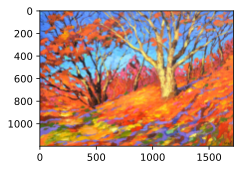

In [2]:
style_img = d2l.Image.open('01_Data/06_autumn-oak.jpg')
d2l.plt.imshow(style_img)

In [3]:
# 预处理和后处理
# 预设的RGB平均值和标准差，用于图像的标准化
rgb_mean = torch.tensor([0.485,0.456,0.406])
rgb_std = torch.tensor([0.229,0.224,0.225])

# 图片预处理函数，将图片转化为适合模型训练的tensor
def preprocess(img, image_shape): # 图片变为训练的tensor
    # 定义图像预处理流程：调整大小、转换为tensor、标准化
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape), # 调整图像大小到指定的image_shape
        torchvision.transforms.ToTensor(), # 将图像转换为tensor
        torchvision.transforms.Normalize(mean=rgb_mean,std=rgb_std) ]) # 使用预设的均值和标准差对图像进行标准化
    # 对输入的img应用上述的预处理流程，并在最前面添加一个新维度（用于batch size），然后返回结果
    return transforms(img).unsqueeze(0)

# 后处理函数，将tensor转化为图片
def postprocess(img): # tensor变为图片
    # 将输入的tensor移动到与rgb_std相同的设备上
    img = img[0].to(rgb_std.device)
    # 反标准化处理：对img的每个像素乘以标准差并加上均值，并确保结果在[0,1]范围内
    img = torch.clamp(img.permute(1,2,0) * rgb_std + rgb_mean, 0, 1)
    # 将处理后的tensor转换为PIL图像，并返回
    return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

In [4]:
# 抽取图像特征
# 加载预训练的VGG19模型
pretrained_net = torchvision.models.vgg19(pretrained=True)

# 这些数字代表取vgg19的某些层
# 定义要从VGG19模型中提取特征的层的索引。
# style_layers用于提取样式特征，content_layers用于提取内容特征。
# 这里选择的层数代表了不同级别的特征，越小的层数越接近输入，提取的特征越接近图像的局部信息。
style_layers, content_layers = [0, 5, 10, 19, 28], [25] # 越小越靠近输入，越靠近输入越匹配局部的信息  

# 根据给定的样式和内容层索引，从预训练的VGG19模型中抽取所需的层，并创建一个新的神经网络。
net = nn.Sequential(*[pretrained_net.features[i]
                     for i in range(max(content_layers + style_layers) + 1)])    

# 定义一个函数，用于从指定层提取特征。
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    # 对于网络中的每一层
    for i in range(len(net)):
        # 在该层上运行输入X以提取特征
        X = net[i](X)  # 每一层抽特征
        # 如果这是一个样式层，将提取的特征添加到样式列表中
        if i in style_layers: # 如果该层为样式层，则返回样式
            styles.append(X)
        # 如果这是一个内容层，将提取的特征添加到内容列表中
        if i in content_layers: # 如果该层为内容层，则返回内容
            contents.append(X)
    # 返回样式列表、内容列表
    return contents, styles

# 定义一个函数，用于处理内容图像并提取内容特征。
def get_contents(image_shape, device):
    # 预处理内容图像并移动到指定设备上
    content_X = preprocess(content_img, image_shape).to(device)
    # 从内容图像中提取内容特征
    content_Y, _ = extract_features(content_X, content_layers, style_layers) 
    # 返回预处理后的内容图像（用于后续的图像合成）和从内容图像中提取的内容特征
    return content_X, content_Y

# 定义一个函数，用于处理样式图像并提取样式特征。
def get_styles(image_shape, device):
    # 预处理样式图像并移动到指定设备上
    style_X = preprocess(style_img, image_shape).to(device)
    # 从样式图像中提取样式特征
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    # 返回预处理后的样式图像（用于后续的图像合成）和从样式图像中提取的样式特征
    return style_X, styles_Y

In [5]:
#定义损失函数
def content_loss(Y_hat, Y):  # 内容损失相差
    # 计算预测的内容特征（Y_hat）与实际的内容特征（Y）之间的均方误差
    return torch.square(Y_hat - Y.detach()).mean()

# Gram矩阵函数，计算输入矩阵（X）的Gram矩阵，用于表示样式特征
def gram(X):
    # 计算通道数和特征数
    num_channels, n = X.shape[1], X.numel() // X.shape[1] 
    # 将输入矩阵reshape为(通道数, 特征数)的格式
    X = X.reshape((num_channels, n))
    # 计算Gram矩阵，并进行规范化处理
    return torch.matmul(X, X.T) / (num_channels * n)

# 样式损失函数
def style_loss(Y_hat, gram_Y): # 样式损失相差
    # 计算预测的样式特征（Y_hat）的Gram矩阵与实际的样式特征（gram_Y）的Gram矩阵之间的均方误差
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

# 总变差损失函数，用于提高生成图像的空间连续性，以减少生成图像的高频噪声
def tv_loss(Y_hat):
    # 计算图像中相邻像素之间的差值的绝对值的平均值
    return 0.5 * (torch.abs(Y_hat[:,:,1:,:] - Y_hat[:,:,:-1,:]).mean()+
                 torch.abs(Y_hat[:,:,:,1:] - Y_hat[:,:,:,:-1]).mean())

In [6]:
# 风格转移的损失函数是内容损失、风格损失和总变化损失的加权和
# 定义内容损失、样式损失和总变差损失的权重
content_weight, style_weight, tv_weight = 1, 1e3, 10

# 定义总损失函数
def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):     
    # 计算内容损失
    # 对于每一层的内容特征，计算预测的内容特征（contents_Y_hat）与实际的内容特征（contents_Y）之间的内容损失，
    # 然后乘以内容损失的权重（content_weight）
    contents_l = [
        content_loss(Y_hat, Y) * content_weight
        for Y_hat, Y in zip(contents_Y_hat, contents_Y) ]
    # 计算样式损失
    # 对于每一层的样式特征，计算预测的样式特征（styles_Y_hat）的Gram矩阵与实际的样式特征（styles_Y_gram）的Gram矩阵之间的样式损失，
    # 然后乘以样式损失的权重（style_weight）
    styles_l = [
        style_loss(Y_hat, Y) * style_weight
        for Y_hat, Y in zip(styles_Y_hat, styles_Y_gram) ]
    # 计算总变差损失，并乘以总变差损失的权重（tv_weight）
    tv_l = tv_loss(X) * tv_weight
    # 计算总损失，它是所有层的内容损失、样式损失和总变差损失的加权和
    l = sum(10 * styles_l + contents_l + [tv_l])
    # 返回每一层的内容损失、样式损失、总变差损失和总损失
    return contents_l, styles_l, tv_l, l

In [7]:
# 初始化合成图像
# 定义一个继承自nn.Module的类，用于表示合成图像
class SynthesizedImage(nn.Module):
    # 构造函数
    def __init__(self, img_shape, **kwargs):
        # 调用父类nn.Module的构造函数
        super(SynthesizedImage, self).__init__(**kwargs)
        # 初始化图像的权重，图像的形状为img_shape，权重的初始值是随机生成的
        self.weight = nn.Parameter(torch.rand(*img_shape))
        
    # 前向传播函数
    def forward(self):
        # 直接返回图像的权重
        return self.weight
    
# 定义一个函数，用于初始化合成图像、样式特征的Gram矩阵和优化器
def get_inits(X, device, lr, styles_Y):
    # 创建一个SynthesizedImage对象，并将其移动到指定的设备上
    gen_img = SynthesizedImage(X.shape).to(device)
    # 将输入的数据X复制到gen_img的权重中
    gen_img.weight.data.copy_(X.data)
    # 使用Adam优化器，优化的目标是gen_img的参数，学习率为lr
    trainer = torch.optim.Adam(gen_img.parameters(),lr=lr)
    # 计算每一层的样式特征的Gram矩阵
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    # 返回合成的图像、样式特征的Gram矩阵和优化器
    return gen_img(), styles_Y_gram, trainer

In [8]:
# 训练模型
# 定义训练函数
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    # 初始化合成图像、样式特征的Gram矩阵和优化器
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    # 定义学习率调度器，每隔lr_decay_epoch个epoch，学习率乘以0.8
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)     
    # 创建一个动画展示器，用于展示每个epoch的内容损失、样式损失和TV损失
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[10,num_epochs], 
                           legend=['content','style','TV'],ncols=2,figsize=(7, 2.5))   
    # 对每个epoch
    for epoch in range(num_epochs):
        # 清零优化器的梯度
        trainer.zero_grad()
        # 提取合成图像的内容特征和样式特征
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)  
        # 计算内容损失、样式损失、TV损失和总损失
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)  
        # 计算总损失的梯度
        l.backward()
        # 使用优化器更新合成图像的像素值
        trainer.step()
        # 更新学习率
        scheduler.step()
        # 每隔10个epoch，展示一次合成图像和各项损失
        if(epoch+1) % 10 == 0:
            # 在animator的第二个子图上显示当前生成的图像
            # postprocess函数将生成的图像从张量转换回PIL图像
            animator.axes[1].imshow(postprocess(X))
            # 在animator中添加当前epoch和对应的内容损失、风格损失和TV损失
            # sum函数用于计算所有元素的和，float函数将结果转换为浮点数
            animator.add(epoch + 1, 
                         [float(sum(contents_l)),
                         float(sum(styles_l)),
                         float(tv_l)])
    # 返回训练得到的合成图像
    return X

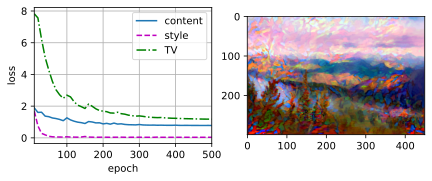

In [9]:
# 训练模型
# 选择设备，如果有可用的GPU，就使用GPU，否则使用CPU
# image_shape定义了生成图像的形状，(300,450)代表生成的图像高为300，宽为450
device, image_shape = d2l.try_gpu(), (300,450)
# 将提取特征的模型移动到指定设备上
net = net.to(device)
# 对内容图像进行预处理，并提取其内容特征
content_X, contents_Y = get_contents(image_shape, device)
# 对样式图像进行预处理，并提取其样式特征
_, styles_Y = get_styles(image_shape, device)
# 训练模型，学习率为0.3，总共训练500个epoch，每50个epoch学习率衰减一次
# 训练结束后返回生成的图像
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)